# Similarity Measurement and Cooperation 

## Introduction

Given the transnational nature of terrorist networks, cooperation is crucial amongst counterterrorism bodies of various objectives and governing bodies. However, cooperation imposes its own set of bureaucratic costs, making it difficult to always carry out in practice. Therefore, effective counterterrorism should seek to strike a balance between too much and too little cooperation with external groups. Too little results in lost opportunities, but too much becomes cumbersome and unhelpful. 

In this notebook, we seek to develop a measure of similarity of terrorist attacks across differet traits of interest. For example, it is useful to understand which terrorist organizations are most similar. By quantifying similarity, instead of just offering a qualitative analysis, we can aid organizations seeking to find the *best* cooperative partners by examining groups whose challenges are similar to their own. For example, Boko Haram and Al Qaeda are very similar, we would recommend that groups interested in countering either of the two groups share observations about attack types, organizational structure, etc. 

## Preprocessing

First, let's load the data from before.

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from scipy.spatial.distance import cdist

In [154]:
import shelve 

#load up intermediate results from counter_terrorism_nb1
with shelve.open('intermediate_results/vars1') as db:
    top_terror_groups = db['top_terror_groups']

In [5]:
from preprocess_functions import load_data_relevant_cols, get_dummies

In [6]:
raw = load_data_relevant_cols()

/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Even after eliminating useless attributes in our preprocessing, we still have a variety of traits in our data which we can use to inform a similarity measure. 

In [60]:
raw.columns.values

array(['iyear', 'imonth', 'iday', 'country', 'country_txt', 'region',
       'region_txt', 'provstate', 'city', 'latitude', 'longitude',
       'specificity', 'success', 'attacktype1', 'attacktype1_txt',
       'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt',
       'natlty1', 'natlty1_txt', 'gname', 'motive', 'weaptype1',
       'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt', 'nkill',
       'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property',
       'propextent', 'propextent_txt', 'propvalue', 'propcomment',
       'ransom', 'ransomamt'], dtype=object)

## Explanation and Assumptions

We want to create a measure of similarity between different terrorist attacks. Given that we have already created a vector representation of the data using a one-hot encoding, a natural way to measure distance is the Euclidean distance on $\mathbb{R}^{n}$, or the $\ell_2$ distance. This distance corresponds to the physical distance between points in space. Formally, if $\vec{x}, \vec{y} \in \mathbb{R}^{n}$, then $$d(\vec{x}, \vec{y}) = \| \vec{x} - \vec{y} \|_2$$

Therefore, we'll create **affinity maps**: Heatmaps which display the 'distance' between different categories in a trait of interest. This is a measure of similarity or dissimilarity between different groups of terrorist attacks. Note the following:

1. For computational efficiency, we compute the distance of the means of the sub-groups rather than the average of pair-wise distances between each subgroup. Given that our dataset has over 170,000 attacks, the latter would be far too expensive to be feasible. 

2. Despite the fact that we are using a heatmap, we are interested in *lower values*, not higher ones. This is because high values indicate a larger distance than smaller ones. 


3. The matrix is symmetric, so looking either the upper or the lower triangular half is all that is needed. This follows from the symmetry property of distance - formally, for any points $i, j$, the distance $d(i, j)$ and $d(j, i)$ are equal. Also, $d(i, i) = 0$ for all $i$. 

4. One of the arguments in the function below is ```percentile_cutoff```, which corresponds to the percentage of distance values that we want to display. Displaying distances below a certain percentile makes the heatmaps easier to read, as the goal of these is to explore which subsets of the data are most similar to one another. 

Because this is simply exploratory analysis, we will simplify the similar measure to only look at a few key attributes. Using the ```get_dummies``` function from ```preprocess_functions.py```, we will create a one-hot encoding of the terrorist attack data with respect to these traits, and then use the discussed $\ell_2$ distance in $\mathbb{R}^{n}$ for measuring how "similar" two attacks are to one another. 

In [37]:
traits_to_compare = ['region_txt', 'targtype1_txt', 'weaptype1_txt', 
                     'iyear', 'nkill', 'natlty1_txt', 'gname']
dummies = get_dummies(raw, traits_to_compare)

In [144]:
def plot_affinity_heatmap(trait_str, attribute, colormap='RdYlBu', percentile_cutoff = 20):     
    trait_labels = [label for label in dummies.columns.values if trait_str in label]
    #remove 'unknown' and 'other' categories
    trait_labels = [label for label in trait_labels if label not in [trait_str + 'Unknown', trait_str + 'Other']]
    
    #calculate means for each category 
    means = []
    for label in trait_labels: 
        means.append(np.mean(dummies[dummies[label] == 1]).drop(index=trait_labels))
    
    #calculate distances and cutoff
    distances = cdist(means, means)
    cutoff = np.percentile(distances, q=percentile_cutoff)
    
    #initialize the figure and make plot labels
    plt.figure(figsize=(12, 8))
    plot_labels = [label.replace(trait_str, '') for label in trait_labels]
    plot_labels = [label.split('(')[0] for label in plot_labels]
    
    #plot the heatmap
    mask_df = pd.DataFrame(distances > cutoff)
    sns.heatmap(distances, cmap=colormap, xticklabels=plot_labels, 
                yticklabels=plot_labels, annot=True, mask=mask_df)
    title_txt = 'Divergence of mean terrorist attack by {}'.format(attribute) 
    if int(percentile_cutoff) != 100: 
        title_txt += ': Most Similar {} Percent'.format(int(percentile_cutoff))
    plt.title(title_txt)

## Affinity by Traits of Interest 

Next, we'll create affinity maps with respect to certain traits of interest, 

### Region 
By examining the affinity map for regions, we should get a sense of which regions have reason to collaborate.

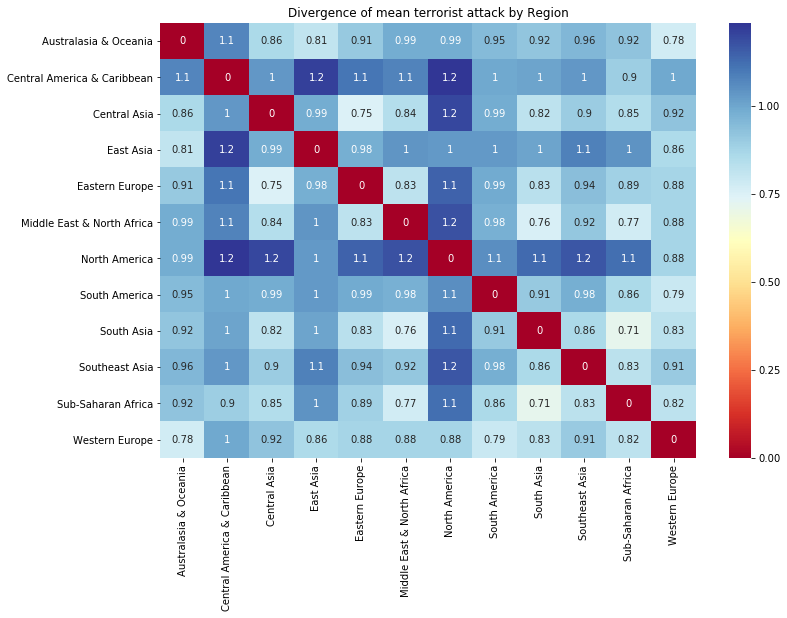

In [145]:
plot_affinity_heatmap('region_txt_', 'Region', percentile_cutoff=100)

Notably, there isn't much variation across regions even when using a multi-attribute measure such as the vectorized Euclidean distance. This seems to be further evidence of our speculation from ```counter_terrorism_nb1``` - terrorist attacks are not that different from region to region, at least according to our particular measure. We already observed this in the case of percentage of successful attacks.

Next, let's display only the top 30% of cells from the previous heatmap, to get a sense of which regions are the most similar to one another. This removes visual clutter from the image.

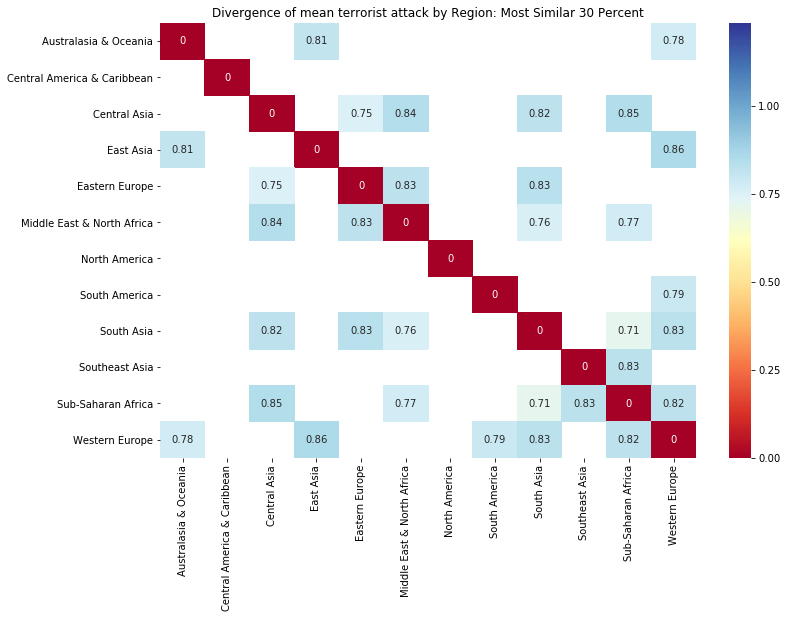

In [146]:
plot_affinity_heatmap('region_txt_', 'Region', percentile_cutoff=30)

### Weapon Type

We repeat the above analysis, but for weapon type.

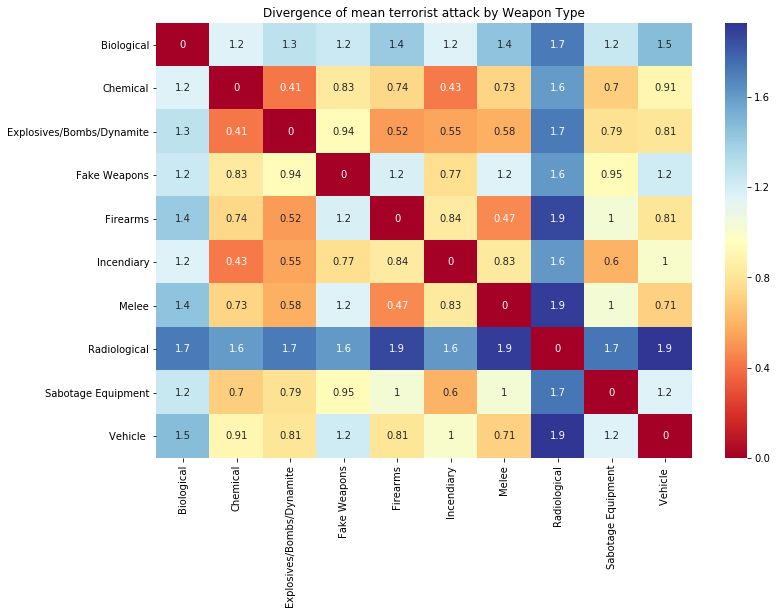

In [147]:
plot_affinity_heatmap('weaptype1_txt_', attribute='Weapon Type', percentile_cutoff=100)

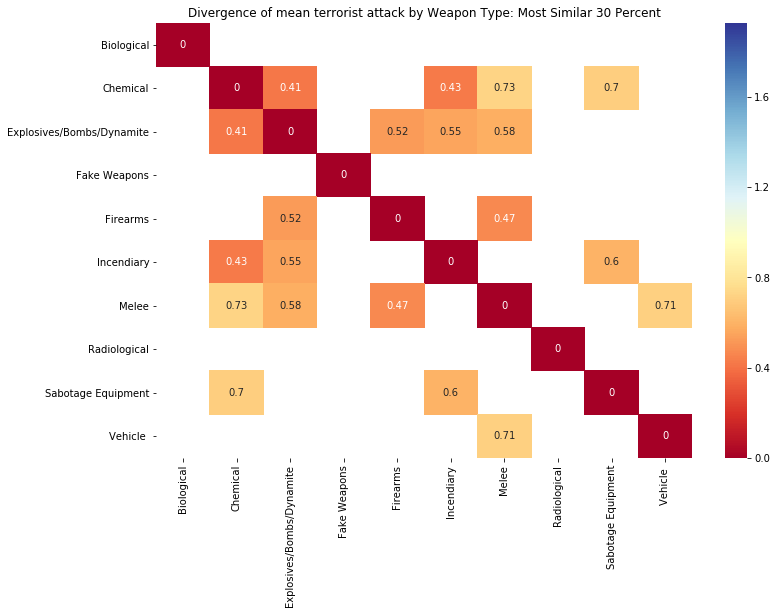

In [148]:
plot_affinity_heatmap('weaptype1_txt_', 'Weapon Type', percentile_cutoff=30)

### Target Type 

Next, we'll examine affinity by target type.

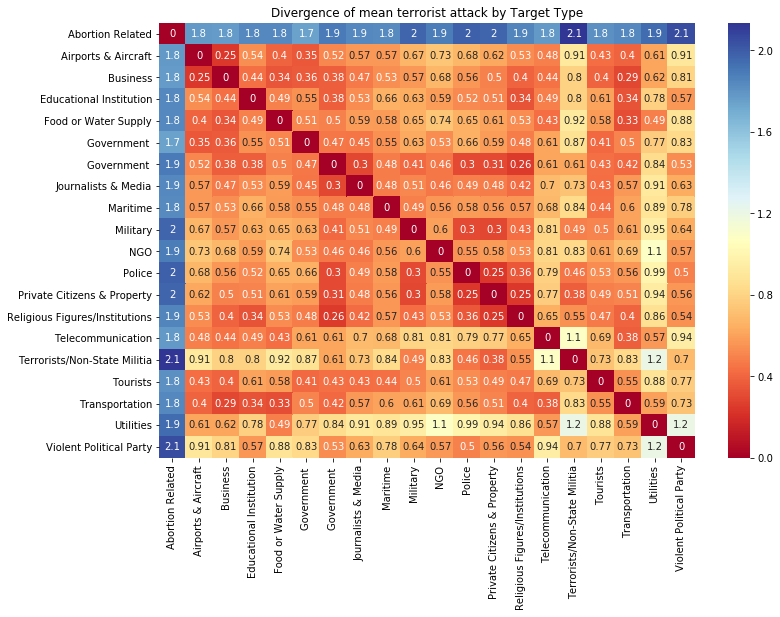

In [151]:
plot_affinity_heatmap('targtype1_txt_', attribute='Target Type', percentile_cutoff=100)

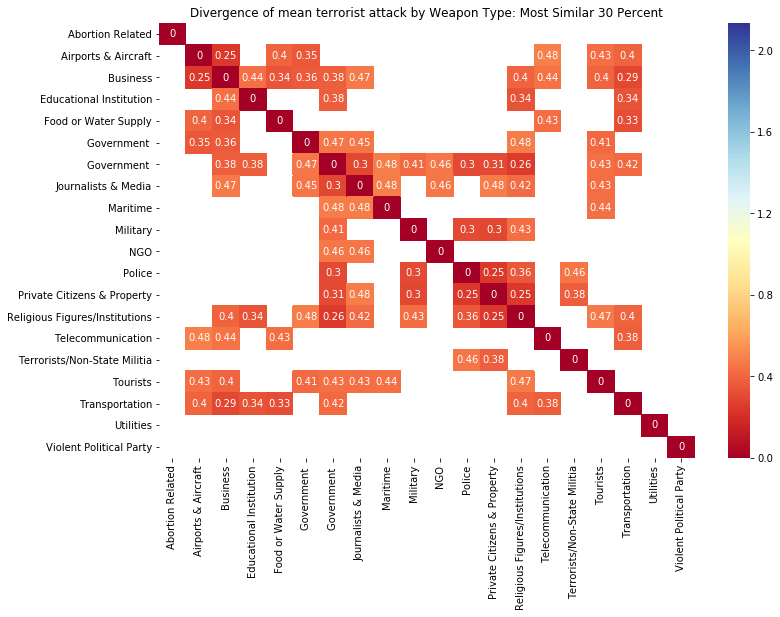

In [152]:
plot_affinity_heatmap('targtype1_txt_', attribute='Weapon Type', percentile_cutoff=30)

### Detour: Explaining Abortion Attacks

In the heatmap above, we saw that abortion-related terrorist attacks sharply diverge from other kinds of attacks. To try to explain why, we'll re-examine the data to see if we made any mistakes, or if this result is legitimate.

In [170]:
abortion_attacks = raw[raw['targtype1_txt'] == 'Abortion Related']
abortion_attacks[traits_to_compare].head()

,region_txt,targtype1_txt,weaptype1_txt,iyear,nkill,natlty1_txt,gname
4471,North America,Abortion Related,Incendiary,1977.0,0.0,United States,Anti-Abortion extremists
4670,North America,Abortion Related,Incendiary,1977.0,0.0,United States,Anti-Abortion extremists
5104,North America,Abortion Related,Incendiary,1977.0,0.0,United States,Anti-Abortion extremists
5427,North America,Abortion Related,Incendiary,1977.0,0.0,United States,Anti-Abortion extremists
5696,North America,Abortion Related,Incendiary,1978.0,0.0,United States,Anti-Abortion extremists


It seems that there aren't many NaN values for abortion-related attacks, so there isn't an issue in the data. However, abortion-related attacks seem to mostly occur in the United States. Let's see if this is the case.

In [172]:
print('There were {} total abortion-related attacks'.format(len(abortion_attacks)))
abortion_attacks[abortion_attacks['region_txt'] != 'North America'][traits_to_compare]

There were 263 total abortion-related attacks


,region_txt,targtype1_txt,weaptype1_txt,iyear,nkill,natlty1_txt,gname
11135,Western Europe,Abortion Related,Explosives/Bombs/Dynamite,1980.0,NaN,Germany,Anti-Abortion extremists
11152,Western Europe,Abortion Related,Explosives/Bombs/Dynamite,1980.0,NaN,West Germany (FRG),Anti-Abortion extremists
11161,Western Europe,Abortion Related,Incendiary,1980.0,NaN,Germany,Anti-Abortion extremists
19983,South America,Abortion Related,Explosives/Bombs/Dynamite,1983.0,0.0,Argentina,Unknown
55079,Western Europe,Abortion Related,Firearms,1994.0,0.0,Great Britain,Ulster Freedom Fighters (UFF)


We were correct. Of 263 attacks, only 5 were not in North America. Given that the Middle East and South Asia are the two most common places of terrorist attacks, this alone can explain much of the divergence. Another possible reason for this divergence might be because it seems most of the attacks were either carried out by "Army of God" or "Anti-Abortion extremists." Let's see if this is the case.

In [168]:
len(abortion_attacks[abortion_attacks['gname'] == 'Army of God'])

22

In [169]:
len(abortion_attacks[abortion_attacks['gname'] == 'Anti-Abortion extremists'])

197

Of the 263 attacks, 219 were either carried out by Army of God, which is a [US-based anti-abortion terrorist group](https://en.wikipedia.org/wiki/Army_of_God_(United_States)) or by 'Anti-Abortion extremists', a category in this database which we assume only refers to anti-abortion groups. Clearly, neither group would carry out attacks against other kinds of targets, such as the police.

We can conclude that the finding at hand - that abortion-related terrorist attacks sharply diverge from other kinds of attacks - is in fact legitimate.

### Terrorist Group

Our data for top terrorist groups is organized differently, so we'll re-work the affinity map function before creating the figures.

In [178]:
group_names = [tuple[0] for tuple in top_terror_groups]

In [196]:
def plot_terrorist_similarity(group_names, colormap='RdYlBu', percentile_cutoff = 20):     
    trait_labels = [label for label in dummies.columns.values if 'gname' in label]
    #remove 'unknown' and 'other' categories
    trait_labels = [label for label in trait_labels if label not in ['gname' + 'Unknown', 'gname' + 'Other']]
    trait_labels = [label for label in trait_labels if label.replace('gname_', '') in group_names]
    
    #calculate means for each category 
    means = []
    for label in trait_labels: 
        means.append(np.mean(dummies[dummies[label] == 1]).drop(index=trait_labels))
    
    #calculate distances and cutoff
    distances = cdist(means, means)
    cutoff = np.percentile(distances, q=percentile_cutoff)
    
    #initialize the figure and make plot labels
    plt.figure(figsize=(12, 8))
    plot_labels = [label.replace('gname_', '') for label in trait_labels]
    plot_labels = [label.split('(')[0] for label in plot_labels]
    
    #plot the heatmap
    mask_df = pd.DataFrame(distances > cutoff)
    sns.heatmap(distances, cmap=colormap, xticklabels=plot_labels, 
                yticklabels=plot_labels, annot=True, mask=mask_df)
    title_txt = 'Divergence of terrorist groups'
    if int(percentile_cutoff) != 100: 
        title_txt += ': Most Similar {} Percent'.format(int(percentile_cutoff))
    plt.title(title_txt)

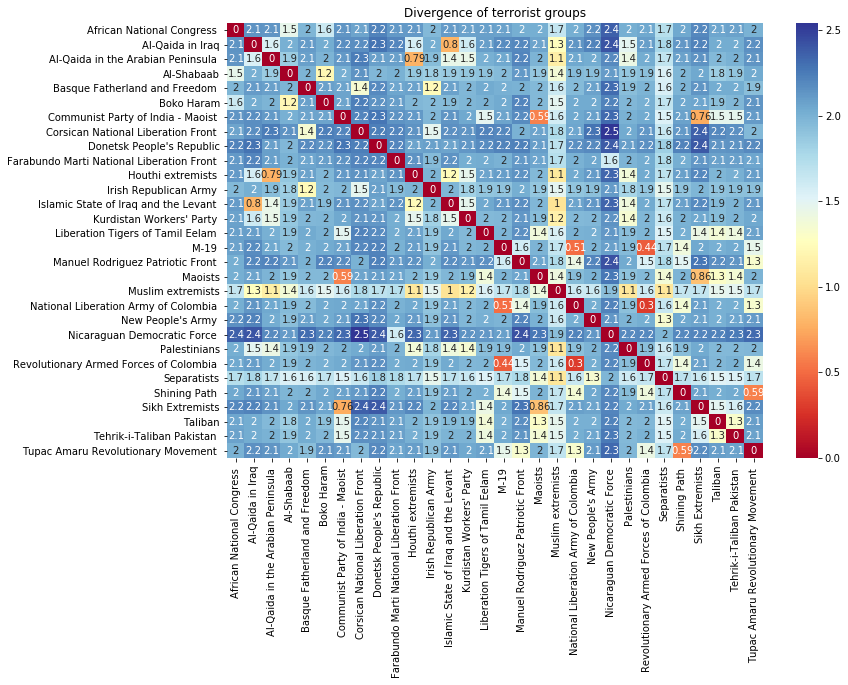

In [197]:
plot_terrorist_similarity(group_names, percentile_cutoff=100)

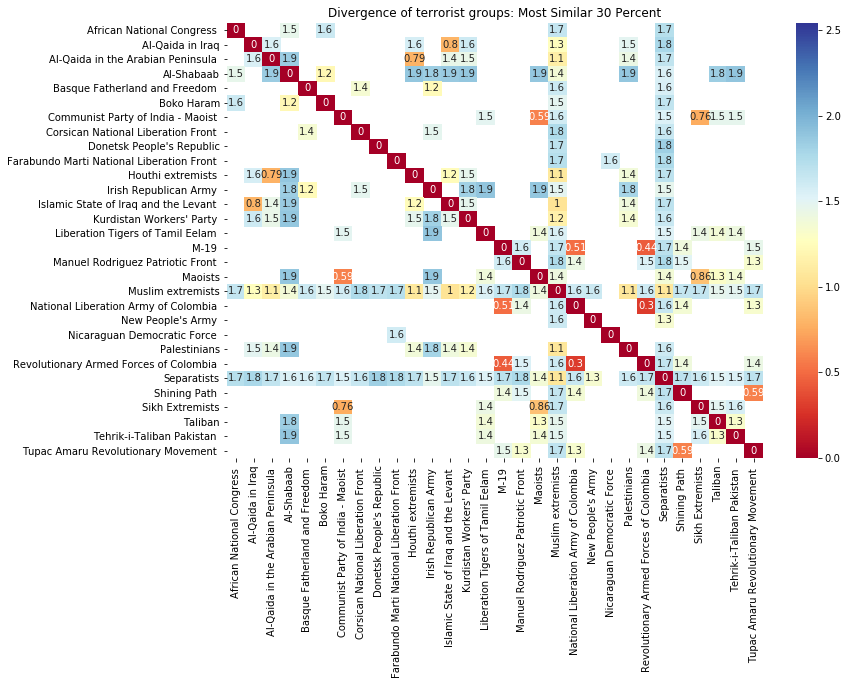

In [198]:
plot_terrorist_similarity(group_names, percentile_cutoff=30)

The similarities found above are quite interesting. We will comment on a few.

1. FARC and M-19, both Colombian terrorist groups, have a very high level of similarity. So do Shining Path and Tupac Amaru Reviolutionary Movement, both from Peru. 

2. The general-purpose groups 'Muslim extremists' and 'Separatists' exhibit a relatively high degree of similarity to most other groups - this makes sense, given that these are not actual groups but just names that classify a variety of groups based on motive. Given that the motives of most of the other groups might be described as Muslim extremism or separatism, we would have predicted this similarity to occur.

## Conclusion

After developing and implementing a similarity measurement on terrorist attacks, we found interesting correlations that should inform collaboration in counter-terrorism. In particular, we compared terrorist attacks by region, weapon type, target type, and group. Regional comparisons were not very useful, because there was not much variance in the similarity measure for different region pairs. A similar issue occurred for target types, although we did find out that abortion-related attacks are substantially different from every other type of terrorist attack - a useful fact for groups seeking to counter anti-abortion extremists. 

Our comparisons of terrorist groups and weapon types proved useful, because these comparisons showed a high degree of variance. This is desirable, because it indicates that there are few similarities which are substantial and deserve further exploration - such as similarities between explosive and chemical attacks.